In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import missingno as msno
import seaborn as sns
%matplotlib inline
import math
from scipy import stats
from scipy.stats import multivariate_normal as mvn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import time

pd.set_option('display.max_columns', None)

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

## Import Data

This dataset can be found on this page:<br>
https://archive.ics.uci.edu/ml/datasets/Facebook+metrics

In [2]:
# Load Data
data_folder = '/Users/bryan/Dropbox/_Shared Between Priyanka and Bryan/_UNL Materials/CSCE 878/Final Project/Facebook_metrics'
# data_folder='/Users/priyanka/Dropbox/shared between priyanka and bryan/_UNL Materials/CSCE 878/Final Project/Facebook_metrics'
properties_file = 'dataset_Facebook.csv'

# Load in data as pandas file
data_df = pd.read_csv(data_folder + '/' + properties_file,';')

# Shuffle rows
data_df_df = data_df.sample(frac=1)
print('The are %i features in this dataset' %len(data_df.columns))

# Make sure no rows corresponding to missing entries for target (logerror)
# merged_df=merged_df[~merged_df['logerror'].isnull()]
# missingdata_df=merged_df.dropna()
# missingdata_df.shape
data_df.head()

The are 19 features in this dataset


,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80
3,139441,Photo,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393


In [3]:
# We now one-hot encode the 'type' feature and include these in the dataframe

merged_df = pd.get_dummies(data_df,prefix=['type'])

merged_df.head()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,type_Link,type_Photo,type_Status,type_Video
0,139441,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100,0,1,0,0
1,139441,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164,0,0,1,0
2,139441,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80,0,1,0,0
3,139441,2,12,2,10,1.0,50128,87991,2211,790,1119,61027,32048,1386,58,1572.0,147.0,1777,0,1,0,0
4,139441,2,12,2,3,0.0,7244,13594,671,410,580,6228,3200,396,19,325.0,49.0,393,0,1,0,0


In [4]:
merged_df.describe()

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,type_Link,type_Photo,type_Status,type_Video
count,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.000000,500.00000,499.000000,496.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,123194.176000,1.880000,7.038000,4.150000,7.840000,0.278557,13903.36000,2.958595e+04,920.344000,798.772000,1415.130000,1.676638e+04,6585.488000,609.986000,7.48200,177.945892,27.266129,212.120000,0.044000,0.852000,0.090000,0.014000
std,16272.813214,0.852675,3.307936,2.030701,4.368589,0.448739,22740.78789,7.680325e+04,985.016636,882.505013,2000.594118,5.979102e+04,7682.009405,612.725618,21.18091,323.398742,42.613292,380.233118,0.205301,0.355456,0.286468,0.117608
min,81370.000000,1.000000,1.000000,1.000000,1.000000,0.000000,238.00000,5.700000e+02,9.000000,9.000000,9.000000,5.670000e+02,236.000000,9.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,112676.000000,1.000000,4.000000,2.000000,3.000000,0.000000,3315.00000,5.694750e+03,393.750000,332.500000,509.250000,3.969750e+03,2181.500000,291.000000,1.00000,56.500000,10.000000,71.000000,0.000000,1.000000,0.000000,0.000000
50%,129600.000000,2.000000,7.000000,4.000000,9.000000,0.000000,5281.00000,9.051000e+03,625.500000,551.500000,851.000000,6.255500e+03,3417.000000,412.000000,3.00000,101.000000,19.000000,123.500000,0.000000,1.000000,0.000000,0.000000
75%,136393.000000,3.000000,10.000000,6.000000,11.000000,1.000000,13168.00000,2.208550e+04,1062.000000,955.500000,1463.000000,1.486050e+04,7989.000000,656.250000,7.00000,187.500000,32.250000,228.500000,0.000000,1.000000,0.000000,0.000000
max,139441.000000,3.000000,12.000000,7.000000,23.000000,1.000000,180480.00000,1.110282e+06,11452.000000,11328.000000,19779.000000,1.107833e+06,51456.000000,4376.000000,372.00000,5172.000000,790.000000,6334.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Holds boolean whether entry is null or not
def nan_investigation(df):
    num_entries = df.shape[0]
    df_titles = list(df.columns.values)
    nan_count_df = pd.DataFrame(columns=df_titles,index=['Tot_Null','Tot_Not_Null','Perc_Null'])
    for column in df:
        nan_sum = df[column].isnull().sum()
        nan_count_df.set_value('Tot_Null', column, nan_sum)
        nan_count_df.set_value('Tot_Not_Null', column, num_entries-nan_sum)
        nan_count_df.set_value('Perc_Null', column, nan_sum/num_entries)

    display(nan_count_df)

In [6]:
# Check to see if any values are actually missing
nan_investigation(merged_df)

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,type_Link,type_Photo,type_Status,type_Video
Tot_Null,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0
Tot_Not_Null,500,500,500,500,500,499,500,500,500,500,500,500,500,500,500,499,496,500,500,500,500,500
Perc_Null,0,0,0,0,0,0.002,0,0,0,0,0,0,0,0,0,0.002,0.008,0,0,0,0,0


In [7]:
# From above we see that one value is missing from Paid and one value is missing from like
# 4 are missing from share
# We believe it is safe to use mean imputation to replace these

merged_df['Paid'].fillna((merged_df['Paid'].mean()), inplace=True)
merged_df['like'].fillna((merged_df['like'].mean()), inplace=True)
merged_df['share'].fillna((merged_df['share'].mean()), inplace=True)
nan_investigation(merged_df)

,Page total likes,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions,type_Link,type_Photo,type_Status,type_Video
Tot_Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Tot_Not_Null,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
Perc_Null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
# For our investigation we choose to make our target feature (Page total likes)
# We now investigate correlations with that feature
merged_df.corr()['Page total likes'].abs().sort_values(ascending=False)

Page total likes                                                       1.000000
Post Month                                                             0.941192
type_Status                                                            0.182867
Lifetime Post Consumers                                                0.149129
Post Hour                                                              0.143807
Lifetime Post Consumptions                                             0.128240
type_Photo                                                             0.123977
Lifetime Engaged Users                                                 0.111922
Lifetime Post Total Impressions                                        0.102540
Lifetime Post Impressions by people who have liked your Page           0.096109
Category                                                               0.091142
type_Link                                                              0.090147
type_Video                              

In [9]:
# We now drop all features with a correlation of less than 10% with our target
keep_list=['Page total likes','Post Month','type_Status','Lifetime Post Consumers','Post Hour',
           'Lifetime Post Consumptions','type_Photo','Lifetime Engaged Users','Lifetime Post Total Impressions']
merged_df = merged_df[keep_list]

In [10]:
# We now investigate how correlated each feature is with each other and remove redundant features
merged_df.corr()

,Page total likes,Post Month,type_Status,Lifetime Post Consumers,Post Hour,Lifetime Post Consumptions,type_Photo,Lifetime Engaged Users,Lifetime Post Total Impressions
Page total likes,1.000000,0.941192,0.182867,-0.149129,-0.143807,-0.128240,-0.123977,-0.111922,-0.102540
Post Month,0.941192,1.000000,0.193058,-0.147083,-0.176390,-0.142829,-0.169050,-0.115898,-0.101616
type_Status,0.182867,0.193058,1.000000,0.410499,-0.042916,0.224030,-0.754553,0.357901,-0.021894
Lifetime Post Consumers,-0.149129,-0.147083,0.410499,1.000000,0.012222,0.706666,-0.294846,0.968213,0.315201
Post Hour,-0.143807,-0.176390,-0.042916,0.012222,1.000000,0.078759,0.086673,0.003879,0.012747
Lifetime Post Consumptions,-0.128240,-0.142829,0.224030,0.706666,0.078759,1.000000,-0.139384,0.676840,0.226081
type_Photo,-0.123977,-0.169050,-0.754553,-0.294846,0.086673,-0.139384,1.000000,-0.247235,-0.018495
Lifetime Engaged Users,-0.111922,-0.115898,0.357901,0.968213,0.003879,0.676840,-0.247235,1.000000,0.368553
Lifetime Post Total Impressions,-0.102540,-0.101616,-0.021894,0.315201,0.012747,0.226081,-0.018495,0.368553,1.000000


We note that Lifetime Engaged Users and Lifetime Post Consumers are highly correlated. We will drop lifetime engaged users as it has a lower correlation with our target.<br>
No other features are extremely correlated with each other.<br>

In [11]:
df_new = merged_df.drop(columns=['Lifetime Engaged Users'])

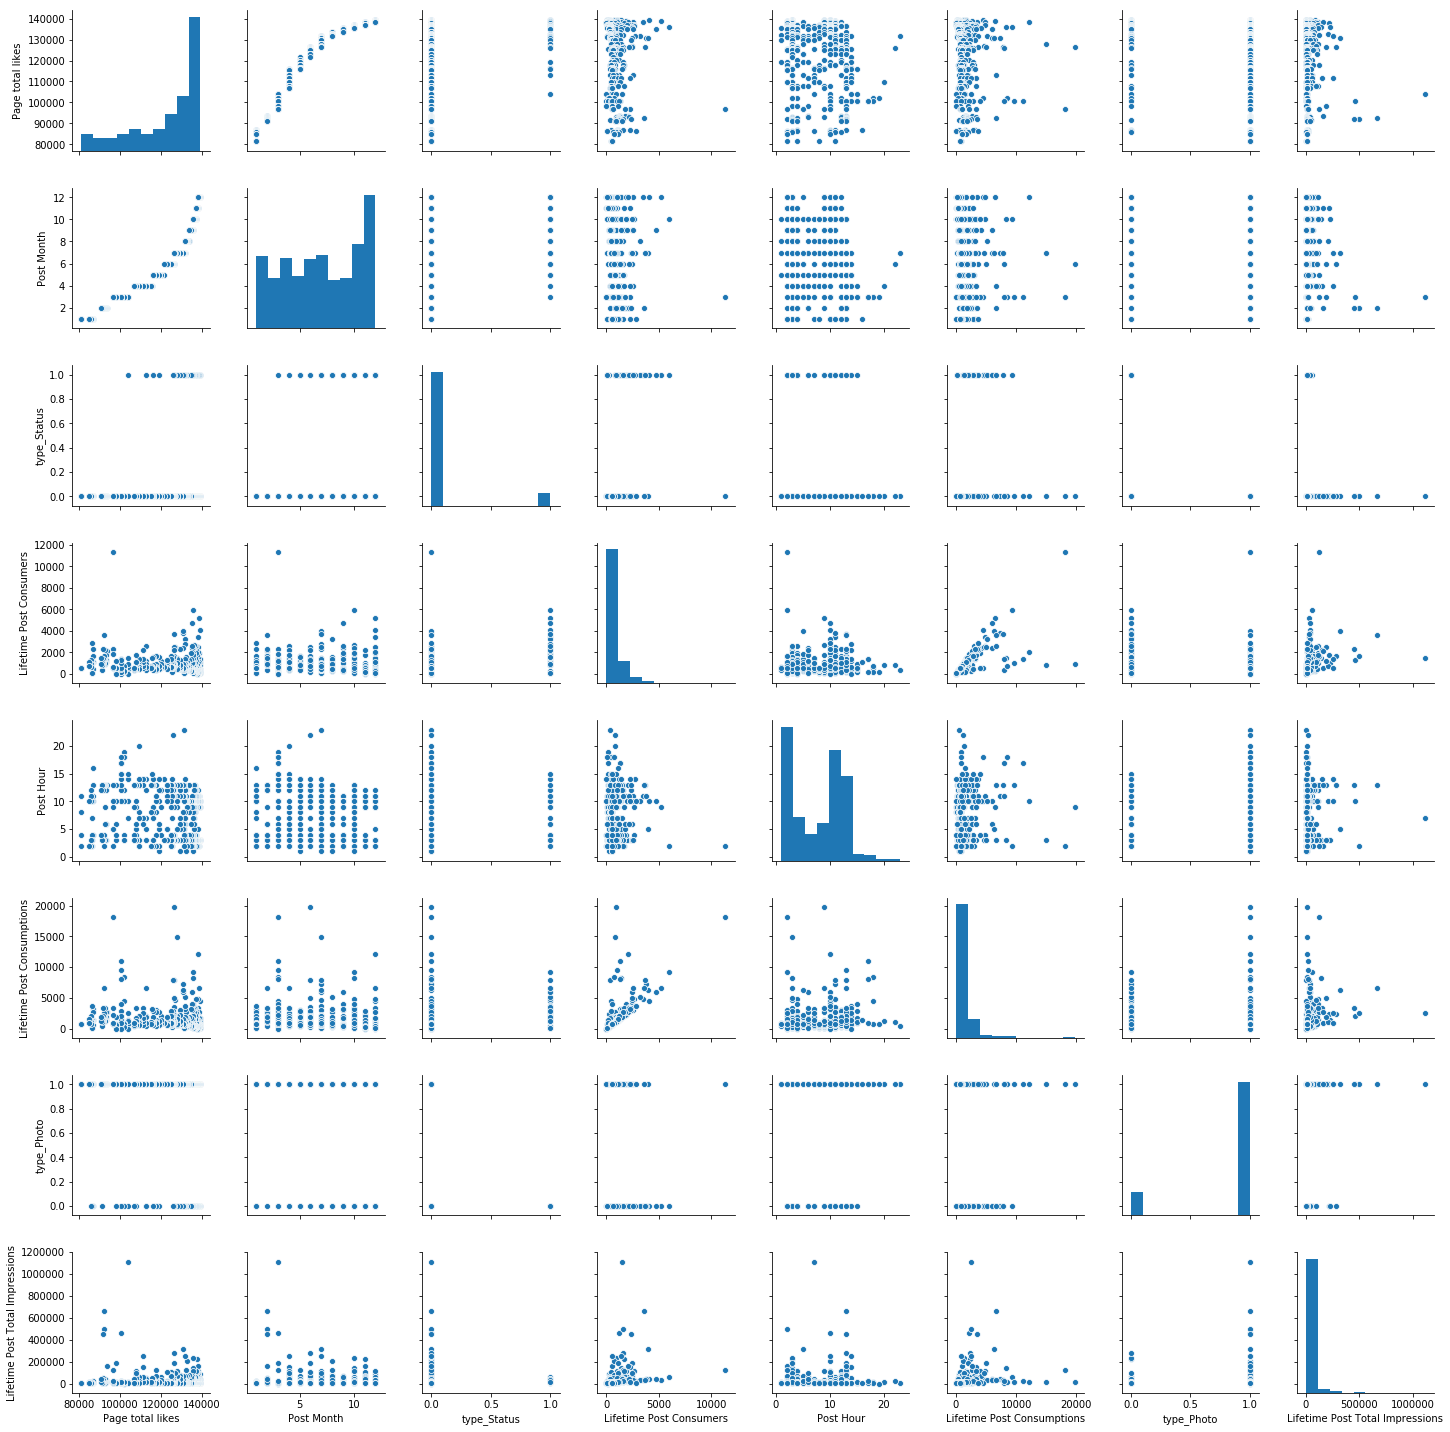

In [12]:
# Now create pairwise plots to see if any other features should be removed
sns.pairplot(df_new)

Aside from correlations with the target, which are fine, we see no reason to remove any additional features based on redundancy.

In [13]:
df_new.corr()['Page total likes'].abs().sort_values(ascending=False)

Page total likes                   1.000000
Post Month                         0.941192
type_Status                        0.182867
Lifetime Post Consumers            0.149129
Post Hour                          0.143807
Lifetime Post Consumptions         0.128240
type_Photo                         0.123977
Lifetime Post Total Impressions    0.102540
Name: Page total likes, dtype: float64

In [14]:
# To avoid problems due to lack of training instances we will restrict ourselves to using only the top 5 features
model_list = ['Page total likes','Post Month','type_Status','Lifetime Post Consumers','Post Hour','Lifetime Post Consumptions']
df_model = df_new[model_list]

## Artificially Remove Data From Top 3 Correlated Features

In [15]:
# For this test, to see how effective imputation is on a limited number of instances and highly correlated feature

# Randomly Remove half of data in feature Post Month (Highest Correlated with Target)
nanidx = df_model.sample(frac=0.5).index
df_model['Post Month'][nanidx] = np.NaN
# Randomly Remove half of data in feature type_Status (2nd highest Correlated with Target)
nanidx = df_model.sample(frac=0.5).index
df_model['type_Status'][nanidx] = np.NaN
# Randomly Remove half of data in feature Lifetime Post Consumers (3rd highest Correlated with Target)
nanidx = df_model.sample(frac=0.5).index
df_model['Lifetime Post Consumers'][nanidx] = np.NaN

# Make a copy of this full model for later
df_orig = df_model

nan_investigation(df_model)

,Page total likes,Post Month,type_Status,Lifetime Post Consumers,Post Hour,Lifetime Post Consumptions
Tot_Null,0,250,250,250,0,0
Tot_Not_Null,500,250,250,250,500,500
Perc_Null,0,0.5,0.5,0.5,0,0


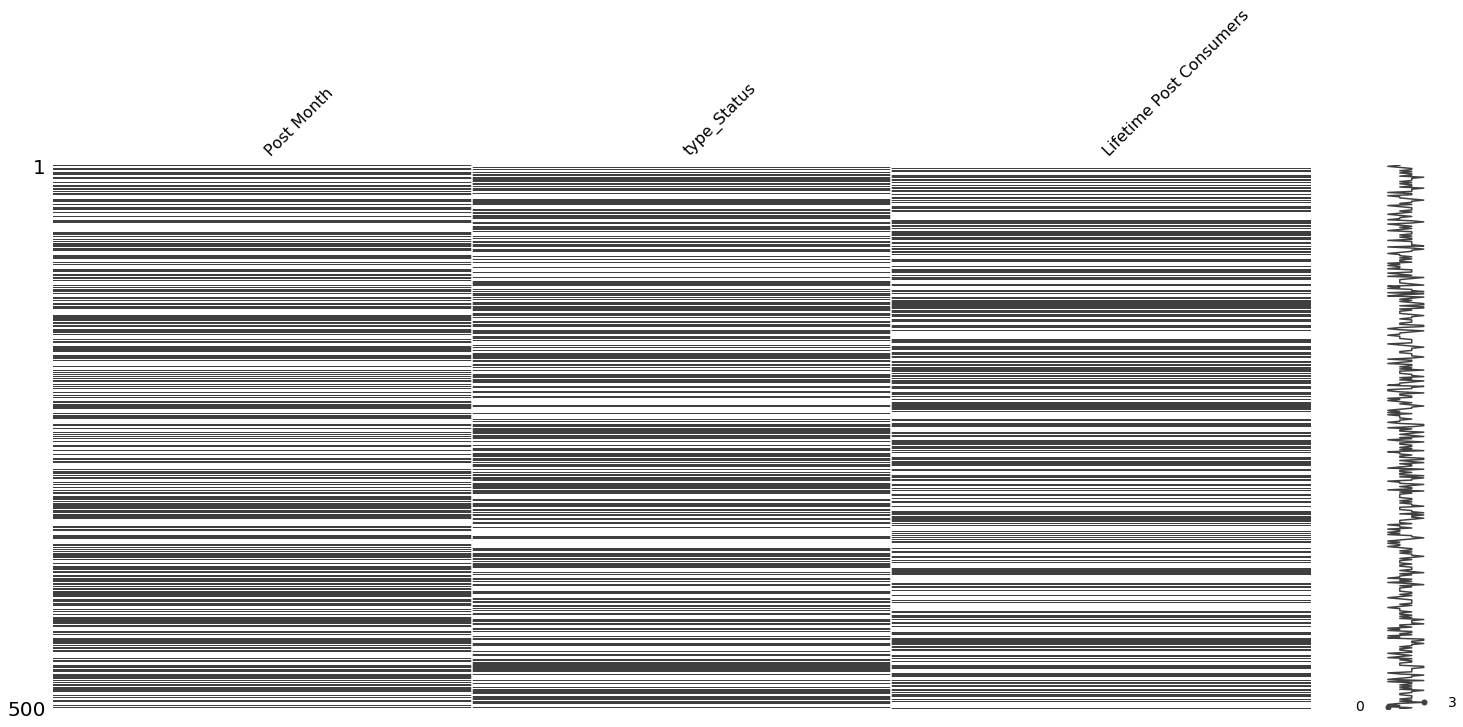

In [16]:
missingdata_df = df_model.columns[df_model.isnull().any()].tolist()
msno.matrix(df_model[missingdata_df])

The above seems to show that the missing data does appear to have been assigned randomly for each.<br>
We now move on to the imputation steps using MICE.

## Perform Mean Imputation

In [17]:
# Make copy of main model
df_model_meanImp = df_model.copy(deep=True)

start_time = time.time()

# Replace missing values for each feature with the mean value of remaining values in that column
df_model_meanImp['Post Month'].fillna((merged_df['Post Month'].mean()), inplace=True)
df_model_meanImp['type_Status'].fillna((merged_df['type_Status'].mean()), inplace=True)
df_model_meanImp['Lifetime Post Consumers'].fillna((merged_df['Lifetime Post Consumers'].mean()), inplace=True)

elapsed_time = time.time() - start_time
print('It took %f seconds to perform Mean imputation on the dataset' %elapsed_time)

nan_investigation(df_model_meanImp)

It took 0.005199 seconds to perform Mean imputation on the dataset


,Page total likes,Post Month,type_Status,Lifetime Post Consumers,Post Hour,Lifetime Post Consumptions
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,500,500,500,500,500,500
Perc_Null,0,0,0,0,0,0


Now create pairwise plots to ensure that this imputation technique has not introduced any new covariances into our features

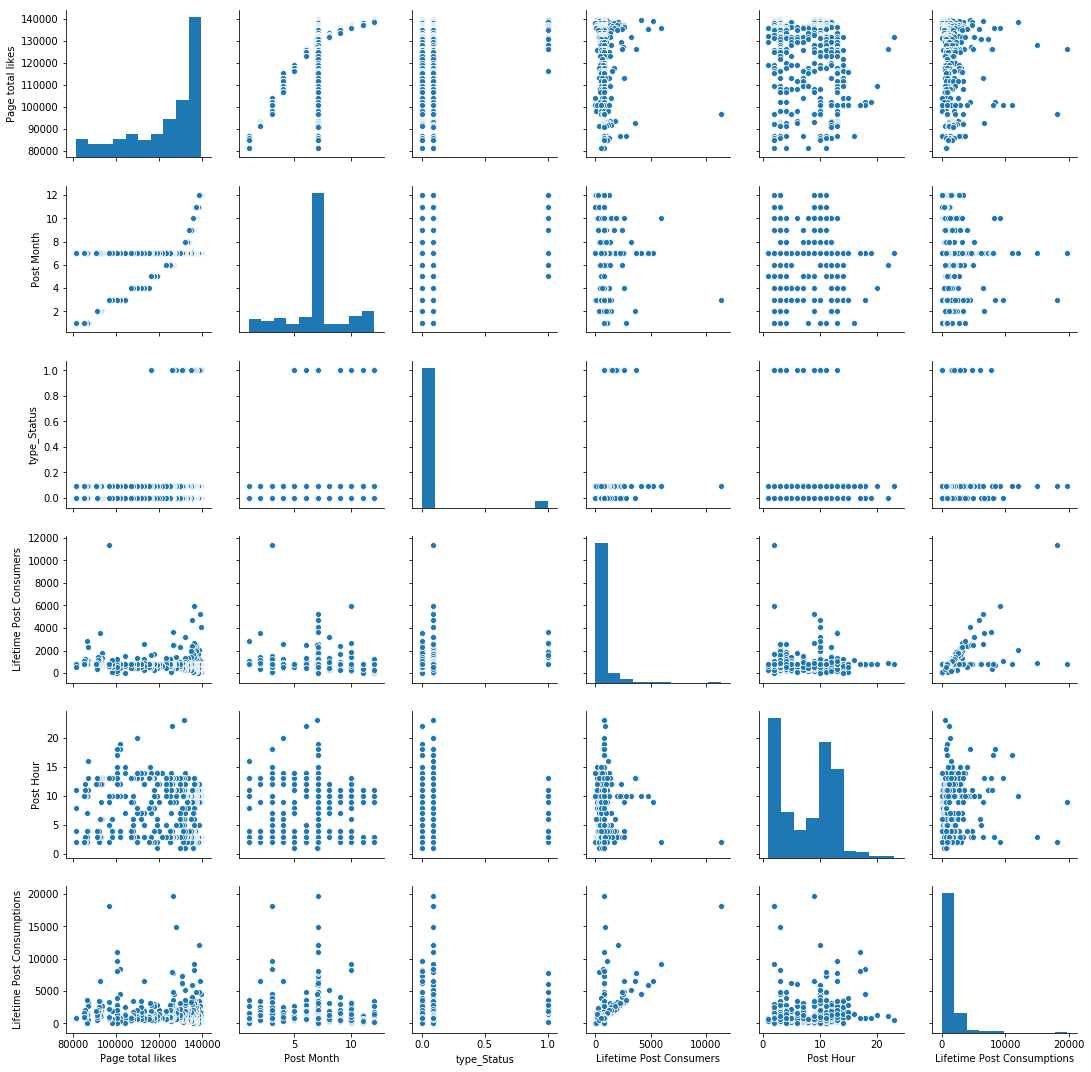

In [18]:
sns.pairplot(df_model_meanImp)

I do not see any reason to suspect that our imputation has introduced any new covariance into our feature set

## Imputation Using Multiple Imputation by Chained Equations (MICE)

In [19]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd

class MiceImputer:
    
    model_dict_ = {}
    
    def __init__(self, seed_nulls=False, seed_strategy='mean'):
        self.seed_nulls = seed_nulls
        self.seed_strategy = seed_strategy
        
    
    def transform(self, X):
        col_order = X.columns
        new_X = []
        mutate_cols = list(self.model_dict_.keys())
        
        for i in mutate_cols:
            y = X[i]
            x_null = X[y.isnull()]
            y_null = y[y.isnull()].reset_index()['index']
            y_notnull = y[y.notnull()]
            
            model = self.model_dict_.get(i)
            
            if self.seed_nulls:
                x_null = model[1].transform(x_null)
            else:
                null_check = x_null.isnull().any()
                x_null = x_null[null_check.index[~null_check]]
            
            pred = pd.concat([pd.Series(model[0].predict(x_null))\
                              .to_frame()\
                              .set_index(y_null),y_notnull], axis=0)\
                              .rename(columns={0: i})
            
            new_X.append(pred)

        new_X.append(X[X.columns.difference(mutate_cols)])

        final = pd.concat(new_X, axis=1)[col_order]

        return final
        
        
    def fit(self, X):      
        x = X.fillna(value=np.nan)

        null_check = x.isnull().any()
        null_data = x[null_check.index[null_check]]
        
        for i in null_data:
            y = null_data[i]
            y_notnull = y[y.notnull()]

            model_list = []
            if self.seed_nulls:
                imp = Imputer(strategy=self.seed_strategy)
                model_list.append(imp.fit(x))
                non_null_data = pd.DataFrame(imp.fit_transform(x))
                
            else:
                non_null_data = x[null_check.index[~null_check]]
                
            
            x_notnull = non_null_data[y.notnull()]
            
            if y.nunique() > 2:
                model = LinearRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})
            else:
                model = LogisticRegression()
                model.fit(x_notnull, y_notnull)
                model_list.insert(0, model)
                self.model_dict_.update({i: model_list})

        return self
        

    def fit_transform(self, X):
        return self.fit(X).transform(X)

We choose to perform 5 iterations using MICE (performing linear regression for each imputation)<br>
Due to the low number of rows not missing any data we did not feel it was adequate to perform cross-validation to choose this, and thus report the results for 5 iterations as the first steps towards beginning our next investigation into multi-column imputation techniques.

In [20]:
# Impute missing values using chained linear equations
start_time = time.time()

model = MiceImputer(seed_nulls=False, seed_strategy='mean')
df_model_MICEImp=model.fit_transform(df_model)

elapsed_time = time.time() - start_time
print('It took %f seconds to perform MICE imputation on the dataset' %elapsed_time)

nan_investigation(df_model_MICEImp)

It took 0.143228 seconds to perform MICE imputation on the dataset


,Page total likes,Post Month,type_Status,Lifetime Post Consumers,Post Hour,Lifetime Post Consumptions
Tot_Null,0,0,0,0,0,0
Tot_Not_Null,500,500,500,500,500,500
Perc_Null,0,0,0,0,0,0


Now create pairwise plots to ensure that this imputation technique has not introduced any new covariances into our features

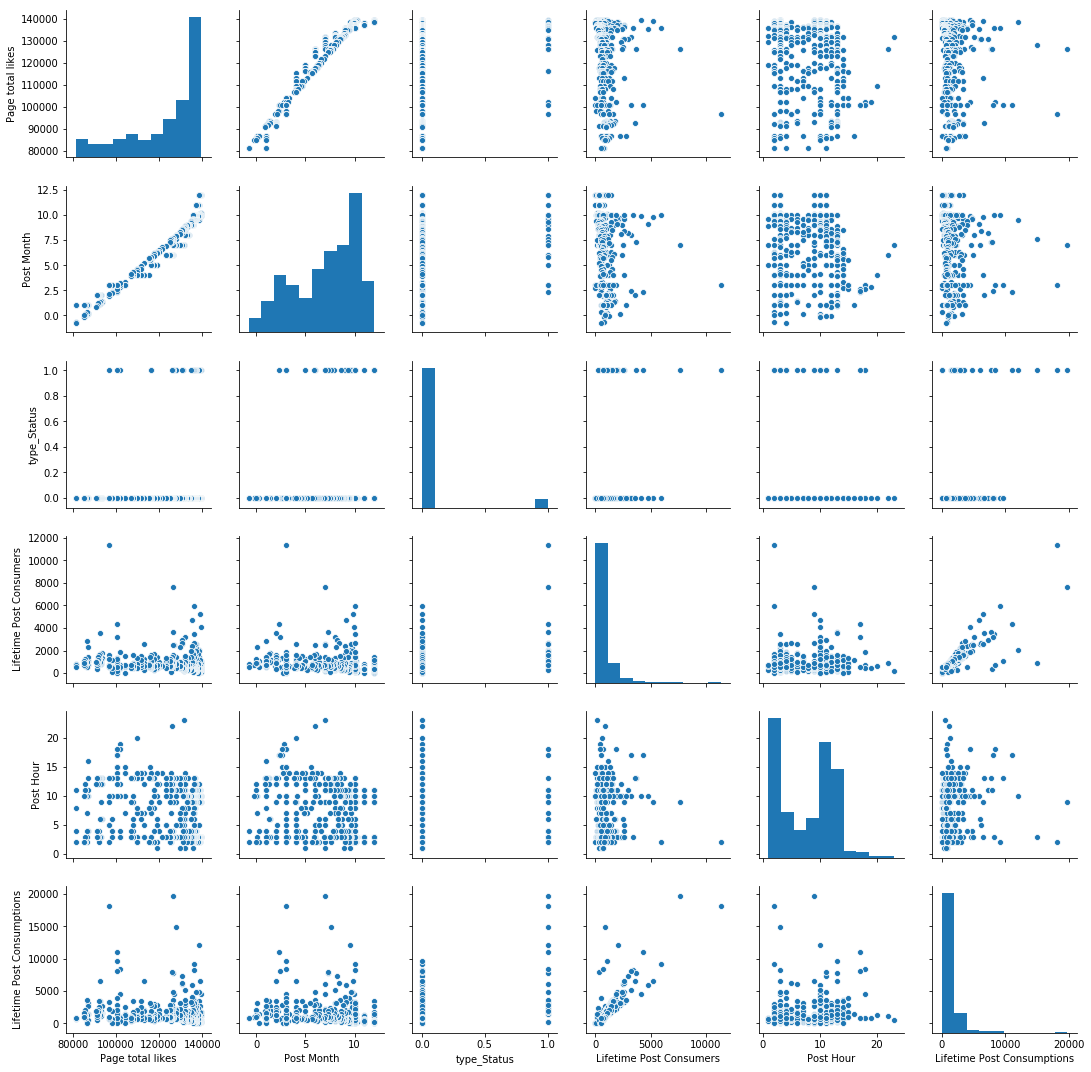

In [21]:
sns.pairplot(df_model_MICEImp)

I do not see any reason to suspect that our imputation has introduced any new covariance into our feature set

## Calculate Prediction Using Rows With No Missing Values

In [22]:
# Let us still see what sort of prediction we can get using test/train split

df_model_noImput = df_orig# Includes all features, including target
# Now drop any rows missing any values
df_model_noImput.dropna(axis=0, how='any', thresh=None, inplace=True)

Y = df_model_noImput['Page total likes'].values
X = df_model_noImput.drop(columns=['Page total likes']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
print(X.shape)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print(X_test.shape)

(60, 5)
(12, 5)


As we only have 13 rows in our test set these results should not be considered significant, but it's still useful to calculate this for comparison.

In [23]:
def vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test):
    mse_train, mse_test = [], []

    for degree in degreeList:
        print('Modeling data using degree: %i' %degree)

        # Create model for current degree polynomial being considered
        model = make_pipeline(PolynomialFeatures(degree, include_bias=False),
                              StandardScaler(), LinearRegression()) 

        # Fit model using the training data for current degree of polynomial
        model.fit(X_train, Y_train)

        # Make prediction for both training and testing datasets
        Y_train_predicted = model.predict(X_train)
        Y_test_predicted = model.predict(X_test)

        # These keep track of MSE for testing and training datasets for each polynomial order considered
        mse_train.append(mean_squared_error(Y_train, Y_train_predicted))
        mse_test.append(mean_squared_error(Y_test, Y_test_predicted))

    # Below plots the “rmse vs. degree”
    plt.figure(figsize=(10, 6))
    plt.plot(degreeList, mse_test, "ro-", alpha=1.0, linewidth=1.0, label="Test MSE")
    plt.plot(degreeList, mse_train, "bo-", alpha=1.0, linewidth=1.0, label="Train MSE")    
    plt.legend(loc="best", fontsize=14) 
    plt.xlabel("Degree")
    plt.ylabel("MSE")
    plt.title("MSE for Varying Degree")
#     plt.ylim(bottom = 0, top=40000) # Adjust the y range to better understand which order of polynomial really becomes a problem
    plt.show()

Modeling data using degree: 1
Modeling data using degree: 2


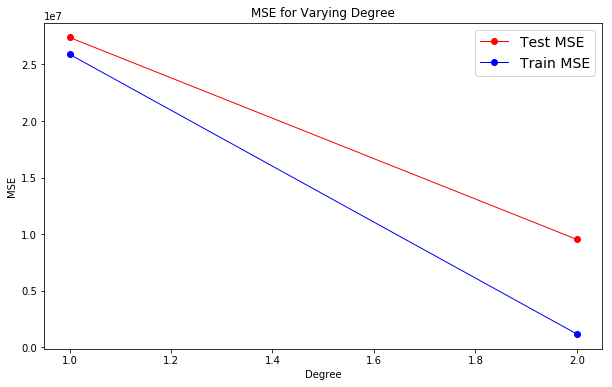

In [24]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

This seems strange. I think it's best to stay with 1st degree regression

In [25]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# We choose 1st order
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [26]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.01 # Regularization Parameter<br>
eta0_opt = 0.01 # learning rate<br>
l1_ratio_opt = 1<br>
learning_rate_opt = 'constant' # (constant or updated during descent)<br>
max_iter_opt = 100<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [27]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.01 # Regularization Parameter
eta0_opt = 0.01 # learning rate
l1_ratio_opt = 1
learning_rate_opt = 'constant' # (constant or updated during descent)
max_iter_opt = 100
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 27637875.537758
The r^2 value for this prediction is 0.897308


## Calculate Prediction Using All Rows (Mean Imputation)

In [28]:
Y = df_model_meanImp['Page total likes'].values
X = df_model_meanImp.drop(columns=['Page total likes']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print(X_test.shape)

(100, 5)


Here we have 100 rows in our test set. This means that our result will be much more meaningful.

Modeling data using degree: 1
Modeling data using degree: 2
Modeling data using degree: 3


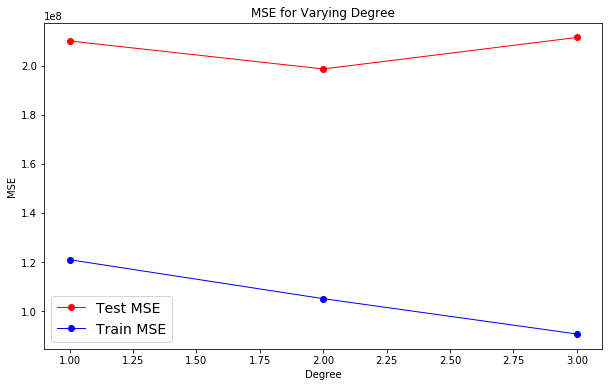

In [29]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2,3]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [30]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [31]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.001 # Regularization Parameter<br>
eta0_opt = 0.1 # learning rate<br>
l1_ratio_opt = 0.5 <br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 400 <br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [32]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.001 # Regularization Parameter
eta0_opt = 0.1 # learning rate
l1_ratio_opt = 0.5 
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 400 
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 213731568.432528
The r^2 value for this prediction is 0.409444


## Calculate Prediction Using All Rows (MICE Imputation)

In [33]:
Y = df_model_MICEImp['Page total likes'].values
X = df_model_MICEImp.drop(columns=['Page total likes']).values

# Scale this feature matrix
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Now separate into test and train portions, keeping 20% in the test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
print(X_test.shape)

(100, 5)


Here we have 100 rows in our test set. This means that our result will be much more meaningful.

Modeling data using degree: 1
Modeling data using degree: 2


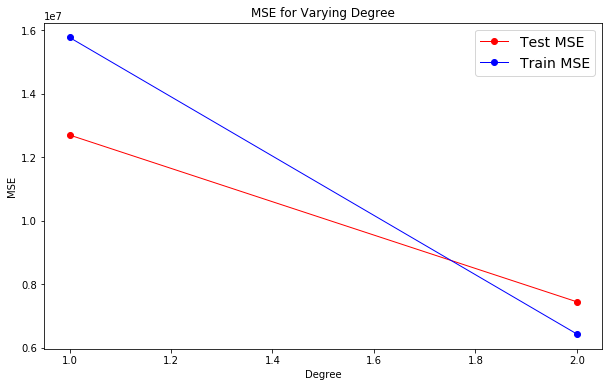

In [34]:
# We will first explore what order of polynomial may be the best predictor for the imputation target column
# For figuring out optimal complexity we use the default options for the linear regressor

degreeList = [1,2]
vary_degree_plot(degreeList,X_train,Y_train,X_test,Y_test)

In [35]:
# From the above results we have chosen an optimal polynomial model for imputing this missing data
# We choose 1st order
poly_degree = 1

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

Note that to check the cross-validation you need to uncomment the below box.<br>
It has been commented out for ease of investigation, as optimization only needs to be run once.

In [36]:
# # First do a grid search to optimize the model
# param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal"], 
#               'l1_ratio': [1, 0.5, 0.2, 0], 'max_iter':[100, 400, 1000, 10000],
#               'eta0': [0.01, 0.001, 0.1]}

# sgd = SGDRegressor()

# sgd_cv = GridSearchCV(sgd, param_grid, scoring='neg_mean_squared_error', cv=5,
#                      n_jobs = -1, verbose = 2)
# sgd_cv.fit(X_train, Y_train)

# # print("Best Score (negative mean squared error): %f" % sgd_cv.best_score_)
# print("Optimal Hyperparameter Values: ", sgd_cv.best_params_)

Here are the optimal hyperparameters we will use:<br>
alpha_opt = 0.1 # Regularization Parameter<br>
eta0_opt = 0.001 # learning rate<br>
l1_ratio_opt = 0.2<br>
learning_rate_opt = 'optimal' # (constant or updated during descent)<br>
max_iter_opt = 10000<br>
penalty_opt = 'elasticnet' # Not chosen by cross-validation

In [37]:
# Using these parameters create SGDRegressor linear regression object
alpha_opt = 0.1 # Regularization Parameter
eta0_opt = 0.001 # learning rate
l1_ratio_opt = 0.2
learning_rate_opt = 'optimal' # (constant or updated during descent)
max_iter_opt = 10000
penalty_opt = 'elasticnet' # Not chosen by cross-validation

# Below creates model based on above optimal parameters
lin_reg_sgd = SGDRegressor(max_iter=max_iter_opt, learning_rate=learning_rate_opt,
                           eta0=eta0_opt, penalty=penalty_opt, l1_ratio=l1_ratio_opt, alpha=alpha_opt)

# Fit the new model
lin_reg_sgd.fit(X_train, Y_train)

Y_test_pred = lin_reg_sgd.predict(X_test)
print('The mean squared error of this prediction is %f' %mean_squared_error(Y_test, Y_test_pred))
print('The r^2 value for this prediction is %f' %r2_score(Y_test,Y_test_pred))

The mean squared error of this prediction is 15227393.434194
The r^2 value for this prediction is 0.926550


## Calculate Average Predictive Error For No Imputation Vs MICE

Note that due to the very low number of samples in the test set for no imputation we have decided to run the notebook 10 times, with the random generator for each approach unseeded, in order to get a better idea of the average performance for each approach.<br>
It is this which will be reported in the paper.

In [38]:
no_Imp_MSE=[181713021.9842,144410295.67508,130657705.642819,152319972.57149,
           158738083.168973,186425038.793577,206747821.220865,
           180276074.296072,111189889.044393,193725799.509331]
no_Imp_r2=[0.320404,0.439386,0.481625,0.356678,0.470902,0.425971,0.14456,0.407332,
          0.524064,0.305749]

mean_Imp_MSE=[162493809.377962,145905036.103152,166769116.855609,167179139.657115,
             165024637.789955,120462459.246089,172696350.560209,
             124599560.455427,146452817.498643,117065075.841162]
mean_Imp_r2=[0.44545,0.358949,0.31441,0.286193,0.344951,0.431205,0.389808,0.539485,
            0.461546,0.513015]

MICE_Imp_MSE=[148339651.111828,164989602.55471,152583590.868856,184902824.171053,
             148769924.774538,174651609.258887,192080187.975502,
             121444549.875367,143358024.751043,151605639.693194]
MICE_Imp_r2=[0.455026,0.387654,0.322374,0.381482,0.469122,0.337597,0.25745,0.43104,
            0.447117,0.398836]

In [39]:
no_Imp_Avg_MSE = np.mean(no_Imp_MSE)
no_Imp_Std_MSE = np.std(no_Imp_MSE)
no_Imp_Avg_r2 = np.mean(no_Imp_r2)
no_Imp_Std_r2 = np.std(no_Imp_r2)

mean_Imp_Avg_MSE = np.mean(mean_Imp_MSE)
mean_Imp_Std_MSE = np.std(mean_Imp_MSE)
mean_Imp_Avg_r2 = np.mean(mean_Imp_r2)
mean_Imp_Std_r2 = np.std(mean_Imp_r2)

MICE_Imp_Avg_MSE = np.mean(MICE_Imp_MSE)
MICE_Imp_Std_MSE = np.std(MICE_Imp_MSE)
MICE_Imp_Avg_r2 = np.mean(MICE_Imp_r2)
MICE_Imp_Std_r2 = np.std(MICE_Imp_r2)

print('The average MSE For Predictions Made Using no imputation is %.2f' %no_Imp_Avg_MSE)
print('The standard deviation for the MSE For Predictions Made Using no imputation is %.2f' %no_Imp_Std_MSE)
print('The average r2 score For Predictions Made Using no imputation is %.2f' %no_Imp_Avg_r2)
print('The standard deviation for the r2 score For Predictions Made Using no imputation is %.2f' %no_Imp_Std_r2)
print('\n')
print('The average MSE For Predictions Made Using mean imputation is %.2f' %mean_Imp_Avg_MSE)
print('The standard deviation for the MSE For Predictions Made Using Mean imputation is %.2f' %mean_Imp_Std_MSE)
print('The average r2 score For Predictions Made Using mean imputation is %.2f' %mean_Imp_Avg_r2)
print('The standard deviation for the r2 score For Predictions Made Using mean imputation is %.2f' %mean_Imp_Std_r2)
print('\n')
print('The average MSE For Predictions Made Using linear MICE is %.2f' %MICE_Imp_Avg_MSE)
print('The standard deviation for the MSE For Predictions Made Using linear MICE is %.2f' %MICE_Imp_Std_MSE)
print('The average r2 score For Predictions Made Using linear MICE imputation is %.2f' %MICE_Imp_Avg_r2)
print('The standard deviation for the r2 score For Predictions Made Using linear MICE imputation is %.2f' %MICE_Imp_Std_r2)

The average MSE For Predictions Made Using no imputation is 164620370.19
The standard deviation for the MSE For Predictions Made Using no imputation is 28700485.41
The average r2 score For Predictions Made Using no imputation is 0.39
The standard deviation for the r2 score For Predictions Made Using no imputation is 0.10


The average MSE For Predictions Made Using mean imputation is 148864800.34
The standard deviation for the MSE For Predictions Made Using Mean imputation is 20228958.91
The average r2 score For Predictions Made Using mean imputation is 0.41
The standard deviation for the r2 score For Predictions Made Using mean imputation is 0.08


The average MSE For Predictions Made Using linear MICE is 158272560.50
The standard deviation for the MSE For Predictions Made Using linear MICE is 20025082.37
The average r2 score For Predictions Made Using linear MICE imputation is 0.39
The standard deviation for the r2 score For Predictions Made Using linear MICE imputation is 0.06
